# Assignment 05 - Recurrent Neural Networks (31 Points Total)
<span style='color:red'> Due date: 15.06.2021 23:59</span>

This week's assignment is about Recurrent Neural Networks and "Unnormalization". If anything is unclear or if you find errors, feel free to post in the forum set up in Ilias or ask in the WebEx live session, or write an email to one of us.

_You can submit incomplete assignments that don't validate_. If a test cell validates correctly, you will get the points. If validation errors occur, you may still get partial or full points if your answer is correct.

## Unnormalization (3 points)
In the last lecture, we got to know *z-score normalization*. The code below demonstrates what happens to a dataset with 3 features:

<IPython.core.display.Javascript object>


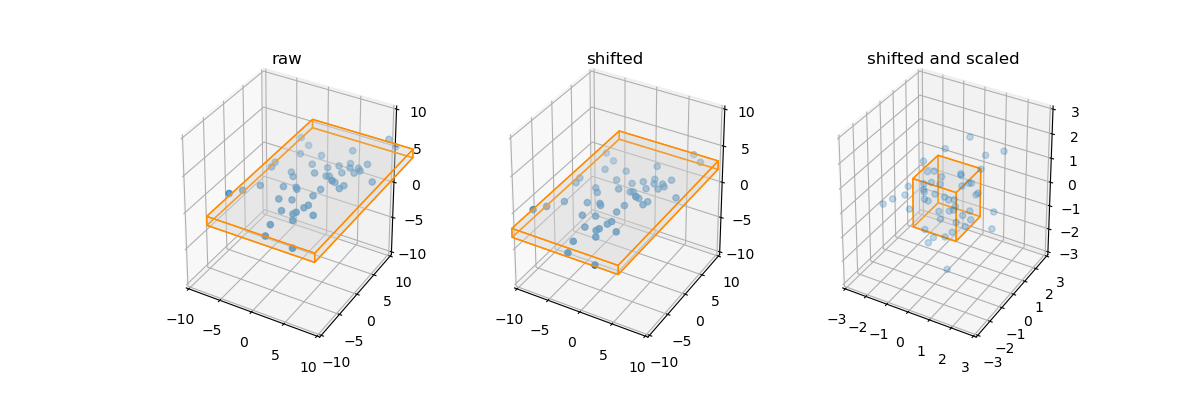

13.925492802264053


In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

def create_cube_3d(origin, sidelengths):
    v1, v2, v3 = [sidelengths[i] * np.eye(3)[i] for i in range(3)]
    origin -= 0.5*(v1 + v2 + v3)
    return [[origin, origin+v1, origin+v1+v2, origin+v2], \
            [origin+v3, origin+v1+v3, origin+v1+v2+v3, origin+v2+v3], \
            [origin, origin+v1, origin+v1+v3, origin+v3], \
            [origin+v1+v2, origin+v2, origin+v2+v3, origin+v1+v2+v3], \
            [origin+v1, origin+v1+v2, origin+v1+v2+v3, origin+v1+v3], \
            [origin+v3, origin+v2+v3, origin+v2, origin]]

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131, projection='3d')
ax1.set_xlim(-10.0, 10.0)
ax1.set_ylim(-10.0, 10.0)
ax1.set_zlim(-10.0, 10.0)
ax1.set_title(label="raw")
ax2 = fig.add_subplot(132, projection='3d')
ax2.set_xlim(-10.0, 10.0)
ax2.set_ylim(-10.0, 10.0)
ax2.set_zlim(-10.0, 10.0)
ax2.set_title(label="shifted")
ax3 = fig.add_subplot(133, projection='3d')
ax3.set_xlim(-3.0, 3.0)
ax3.set_ylim(-3.0, 3.0)
ax3.set_zlim(-3.0, 3.0)
ax3.set_title(label="shifted and scaled")

f1 = np.random.normal(loc=3, scale=4, size=50)
f2 = np.random.normal(loc=1, scale=7, size=50)
f3 = np.random.normal(loc=2, scale=0.3, size=50)

m1 = f1 - np.mean(f1)
m2 = f2 - np.mean(f2)
m3 = f3 - np.mean(f3)

n1 = m1 / np.sqrt(np.var(m1))
n2 = m2 / np.sqrt(np.var(m2))
n3 = m3 / np.sqrt(np.var(m3))
print(np.var(f1))
rhombus1 = create_cube_3d(np.array([3.0, 1.0, 2.0]), [16.0, 28.0, 1.2])
rhombus2 = create_cube_3d(np.array([0.0, 0.0, 0.0]), [16.0, 28.0, 1.2])
rhombus3 = create_cube_3d(np.array([0.0, 0.0, 0.0]), [ 2.0,  2.0, 2.0])

ax1.scatter(f1, f2, f3)
ax1.add_collection3d(Poly3DCollection(rhombus1, 
     facecolors='lightgray', linewidths=1, edgecolors='darkorange', alpha=.25))

ax2.scatter(m1, m2, m3)
ax2.add_collection3d(Poly3DCollection(rhombus2, 
     facecolors='lightgray', linewidths=1, edgecolors='darkorange', alpha=.25))

ax3.scatter(n1, n2, n3, alpha=0.25)
ax3.add_collection3d(Poly3DCollection(rhombus3, 
     facecolors='lightgray', linewidths=1, edgecolors='darkorange', alpha=.25, zorder=100))



Sometimes it's necessary to undo such a normalization, e.g. when it was applied also to the ground truths of a dataset, which sometimes makes sense when the ground truth spans several orders of magnitude for example. In the following cell, write a function called `unnormalize` that takes as input a *normalized* feature (e.g. `n1` from above), its mean and variance, then returns the "unnormalized" features. So in the end, it should return the original feature from before the normalization.

In [42]:
### BEGIN SOLUTION
def unnormalize(n, m, v):
    return n*np.sqrt(v) + m
### END SOLUTION

# check if it worked with feature f1
nn = unnormalize(n1, np.mean(f1), np.var(f1))
print(f1[:6])
print(nn[:6])

[ 4.71950055 -1.08270837 -1.60782255  5.80085222 -3.93054859  4.77751602]
[ 4.71950055 -1.08270837 -1.60782255  5.80085222 -3.93054859  4.77751602]


In [39]:
assert np.allclose(unnormalize(n2, np.mean(f2), np.var(f2)), f2)

---

## Double Pendulum (28 points)
### Part 1: Single Feature Prediction (12 points)
A double pendulum is a highly dynamic system exhibiting chaotic behavior. You can find a description and how to derive the governing equation systems on [Wikipedia](https://en.wikipedia.org/wiki/Double_pendulum) for example. The approach here uses *generalized coordinates*, the angles and angular velocities of each pendulum.

The code below solves the equation system of a double pendulum for the generalized coordinates $\phi_1$, $\phi_2$ (the angles of each pendulum), $\dot \phi_1$ and $\dot \phi_2$ (the angular velocities of each pendulum). This numerical computation part was taken and adapted from the [Matplotlib Documentation](https://matplotlib.org/3.1.1/gallery/animation/double_pendulum_sgskip.html). Unfortunately, the animations didn't work as intended but you could copy the code to your local system and create side-by-side animations of the numerical solution and the predictions.

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Pendulum rod lengths (m), bob masses (kg).
L1, L2 = 1, 1
m1, m2 = 1, 1
# The gravitational acceleration (m.s-2).
g = 9.81

def deriv(y, t, L1, L2, m1, m2):
    """Return the first derivatives of y = theta1, z1, theta2, z2."""
    ϕ1, z1, ϕ2, z2 = y

    c, s = np.cos(ϕ1-ϕ2), np.sin(ϕ1-ϕ2)

    ϕ1dot = z1
    z1dot = (m2*g*np.sin(ϕ2)*c - m2*s*(L1*z1**2*c + L2*z2**2) -
             (m1+m2)*g*np.sin(ϕ1)) / L1 / (m1 + m2*s**2)
    ϕ2dot = z2
    z2dot = ((m1+m2)*(L1*z1**2*s - g*np.sin(ϕ2) + g*np.sin(ϕ1)*c) + 
             m2*L2*z2**2*s*c) / L2 / (m1 + m2*s**2)
    return ϕ1dot, z1dot, ϕ2dot, z2dot

def calc_E(y):
    """Return the total energy of the system."""

    ϕ1, ϕ1dot, ϕ2, ϕ2dot = y.T
    
    V = -(m1+m2)*L1*g*np.cos(ϕ1) - m2*L2*g*np.cos(ϕ2)
    T = 0.5*m1*(L1*ϕ1dot)**2 + 0.5*m2*((L1*ϕ1dot)**2 + (L2*ϕ2dot)**2 + \
            2*L1*L2*ϕ1dot*ϕ2dot*np.cos(ϕ1-ϕ2))
    return T + V

# Maximum time, time point spacings and the time grid (all in s).
tmax, dt = 30, 0.01
t = np.arange(0, tmax+dt, dt)

# Initial conditions: theta1, dtheta1/dt, theta2, dtheta2/dt.
#y0 = np.array([3*np.pi/7, 0, 3*np.pi/4, 0])
y0 = np.array([-np.pi/4, 0, -np.pi/3, 0])

# Do the numerical integration of the equations of motion
y = odeint(deriv, y0, t, args=(L1, L2, m1, m2))

# Check that the calculation conserves total energy to within some tolerance.
EDRIFT = 0.05
# Total energy from the initial conditions
E = calc_E(y0)
if np.max(np.sum(np.abs(calc_E(y) - E))) > EDRIFT:
    sys.exit('Maximum energy drift of {} exceeded.'.format(EDRIFT))



The simulation is done for a $T = 30\,$s period with time steps of $\Delta t = 0.01\,$s. The solutions `y` will contain the angles and angular velocities for each time step:

In [3]:
print(y)

[[-0.78539816  0.         -1.04719755  0.        ]
 [-0.78513262  0.05310184 -1.04702926  0.03366478]
 [-0.78433637  0.10613003 -1.04652402  0.06740144]
 ...
 [-0.7972464  -1.066244   -0.86862772 -0.11490371]
 [-0.8075836  -1.00093493 -0.86972293 -0.10442467]
 [-0.81726013 -0.93413485 -0.87072164 -0.09557643]]


We can plot the angles and angular velocities against time to get a feeling for how they behave:

<IPython.core.display.Javascript object>


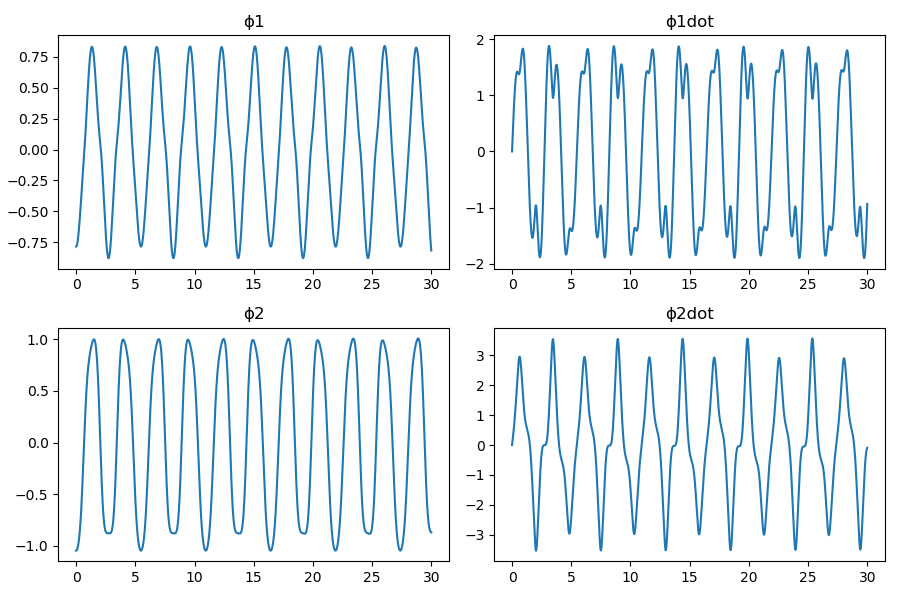

In [4]:
def plot_phis(t, y):
    fig, axs = plt.subplots(2, 2, figsize=(9,6))
    axs = axs.flatten()
    titles = ["ϕ1", "ϕ1dot", "ϕ2", "ϕ2dot"]

    for i in range(len(axs)):
        axs[i].plot(t, y[:,i])
        axs[i].set_title(titles[i])
    
    plt.tight_layout()
        
plot_phis(t, y)

Note that we have chosen quite tame initial conditions and these graphs would look a lot more chaotic with larger initial angles or angular velocities, but we're already in the nonlinear regime here. 

We're going to approximate these developments using an LSTM, so that in the end, we can give the system arbitrary initial sequences (they could be of size 1, so just the initial conditions) and create a trajectory that does not deviate too much from the corresponding numerical solution. In other words, we're going to teach the LSTM chaotic dynamics.

The function below takes a dataset and prepares a new dataset with values arranged appropriately for RNNs. You don't have to do anything here, but it makes sense to understand what exactly it does. This function was taken and adapted from the TensorFlow [Tutorial on Time-Series Forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series).

In [2]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

The next cell will perform the data preparation. RNNs need a specific data format. Execute the cell below to see in what shape the training arrays are put into the network and how their values relate to each other. Here, only the second feature $\dot \phi_1$ of `y` is used, since it looks the most interesting in the graphs above.

In [6]:
# testplit as usual, so we get untouched data for later evaluation
testsplit = int(0.8 * y.shape[0])

# how many "x" inputs to provide in the RNN
past_history = 300

# how many "yhat" outputs to make/how many timesteps into the future to predict
future_target = 100

# this can be set to 1. If you have extremely large datasets where values 
# don't change a lot during single time steps, this can be set to a higher
# value such that, e.g., only every 6th time step is used 
step = 1

# prepare the data
# inputs here are y[:,1] and y[:,1], since we're only going to predict a single feature at first 
# "single_step" needs to be set to "True" if only the next timestep should be predicted
x_train_single, y_train_single = multivariate_data(y[:,1], y[:,1], 0, testsplit, 
                                                   past_history, future_target, step,
                                                   single_step=False)
x_test_single, y_test_single   = multivariate_data(y[:,1], y[:,1], testsplit, None, 
                                                   past_history, future_target, step,
                                                   single_step=False)

# the network later expects arrays with 3 dimensions, so we have to reshape
# the x_... arrays to reflect that they contain a single feature
x_train_single = x_train_single.reshape(*x_train_single.shape, 1)
x_test_single  = x_test_single.reshape( *x_test_single.shape, 1)

# print shapes
print("shape of y:", y.shape)
print("shapes of x_train and y_train: ", x_train_single.shape, y_train_single.shape)
print("shapes of x_test and y_test: ", x_test_single.shape, y_test_single.shape)

# print a few values
print("")
print(x_train_single[:3,:3])

print()
print("x_train[300]: ", *x_train_single[300][:3], "...")
print("y_train[0] :  ", y_train_single[0][:3], "...")

shape of y: (3001, 4)
shapes of x_train and y_train:  (2100, 300, 1) (2100, 100)
shapes of x_test and y_test:  (201, 300, 1) (201, 100)

[[[0.        ]
  [0.05310184]
  [0.10613003]]

 [[0.05310184]
  [0.10613003]
  [0.15901095]]

 [[0.10613003]
  [0.15901095]
  [0.21167103]]]

x_train[300]:  [1.64884751] [1.68471575] [1.71763926] ...
y_train[0] :   [1.64884751 1.68471575 1.71763926] ...


In the array above you can see that the first row of the second sample is equal to the second row of the first sample. The first row of the third sample is identical to the third row of the first sample and so on. So the function above create dataset consisting of 300 consecutive samples from the original dataset, all set apart by a 1 timestep. The `y_train_single` array consists of the following 100 samples from the original set. In other words, if the original time series array y looks like

x0<br />
x1<br />
x2<br />
x3<br />
x4<br />
...

then the training samples `x_train`, `y_train` look like

[x0, x1, x2, x3, x4, ...], [x300, x301, ...]<br />
[x1, x2, x3, x4, x5, ...], [x301, x302, ...]<br />
[x2, x3, x4, x5, x6, ...], [x302, x303, ...]

and so on. The following cell contains the model. We can use a simple one at first, since we're only predicting a single feature.

In [7]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.backend import clear_session
# clear_session() deletes stale model, so that when this cell is executed again,
# no older model reside in memory
clear_session()

# r2_score defined manually, since it's not implemented in keras
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# below, create a sequential model like before called "single_feature_model"
# 
# then, add an LSTM layer (the class is already imported) with 128 hidden
# vector components. As a second argument you have to provide the
# "input_shape=", that has to be a tuple of the second and third dimension
# of x_train_single, like (20, 30). You can use x_train_single.shape for example to get them
# 
# lastly, add a "Dense" layer like in the lessons before, with as many neurons as
# there are future predictions. That number is saved in the variable "future_target".
# choose an appropriate activation function here. Which ones make sense?
### BEGIN SOLUTION
single_feature_model = Sequential()
single_feature_model.add(LSTM(128, input_shape=x_train_single.shape[-2:]))
single_feature_model.add(Dense(future_target, activation='selu'))
### END SOLUTION

# compile the model with the optimizer 'adam', an appropriate loss function, and 
# the "r2_score" defined above as a metric
### BEGIN SOLUTION
single_feature_model.compile(optimizer='adam', loss='mae', metrics = [r2_score])
### END SOLUTION

# check what the model looks like
single_feature_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 100)               12900     
Total params: 79,460
Trainable params: 79,460
Non-trainable params: 0
_________________________________________________________________


In [8]:
assert len(single_feature_model.layers) >= 2
assert "LSTM" in str(single_feature_model.layers[0])
assert "Dense" in str(single_feature_model.layers[-1])



Let's train the model. We don't need a lot of epochs, since the initial conditions we chose in the beginning were rather tame. Call the `fit` method of your model with the training data `x_train_single` and `y_train_single`, 5 epochs and a validation split of 0.25. Save the results in a variable called `single_feature_history`, that we can later use to plot the training history.

In [10]:
### BEGIN SOLUTION
single_feature_history = single_feature_model.fit(x_train_single, y_train_single, epochs=5, validation_split=0.25)
### END SOLUTION

Train on 1575 samples, validate on 525 samples
Epoch 1/5
1575/1575 [==============================] - 21s 14ms/sample - loss: 0.8920 - r2_score: 0.2964 - val_loss: 0.5588 - val_r2_score: -0.4544
Epoch 2/5
1575/1575 [==============================] - 19s 12ms/sample - loss: 0.3776 - r2_score: 0.8463 - val_loss: 0.2965 - val_r2_score: 0.6089
Epoch 3/5
1575/1575 [==============================] - 20s 12ms/sample - loss: 0.2641 - r2_score: 0.9310 - val_loss: 0.2165 - val_r2_score: 0.7573
Epoch 4/5
1575/1575 [==============================] - 20s 12ms/sample - loss: 0.2132 - r2_score: 0.9542 - val_loss: 0.2237 - val_r2_score: 0.7666
Epoch 5/5
1575/1575 [==============================] - 20s 13ms/sample - loss: 0.1976 - r2_score: 0.9607 - val_loss: 0.1756 - val_r2_score: 0.8173


In [11]:
assert single_feature_history.history["val_r2_score"][-1] > 0.75
assert "r2_score" in single_feature_history.history.keys()

It should be possible to get an R² score above 0.75, but you might have to rerun the training to get there. 

The following function can be reused later to plot the loss and validation loss of training:

In [3]:
print(single_feature_history.history.keys())

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    val_r2_score = history.history['val_r2_score']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, lw=4, label='Training loss')
    plt.plot(epochs, val_loss, lw=4, label='Validation loss')
    plt.plot(epochs, val_r2_score, lw=4, label='Validation R² score')
    plt.title(title)
    plt.legend()

    plt.show()
    
plot_train_history(single_feature_history, 'Single Feature Training and Validation Loss')

NameError: name 'single_feature_history' is not defined

It should seem like it's working. Let's check the prediction:

In [13]:
# save the predictions of your model for 'x_test_single' into a variable called 'y_hat'
### BEGIN SOLUTION
y_hat = single_feature_model.predict(x_test_single)
### END SOLUTION

<IPython.core.display.Javascript object>


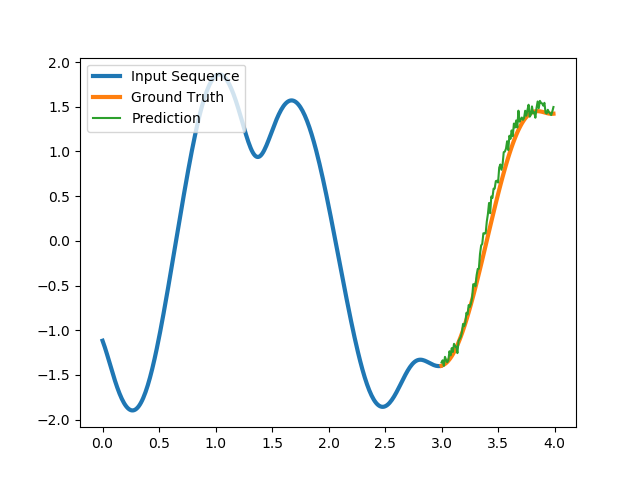

In [15]:
plt.figure()

plt.plot(t[:past_history], x_test_single[0,:], lw=3, label="Input Sequence")
plt.plot(t[past_history:past_history+future_target], y_test_single[0], lw=3, label="Ground Truth")
plt.plot(t[past_history:past_history+future_target], y_hat[0], label="Prediction")
plt.legend(loc='upper left')

plt.show()

The graph would be a lot smoother with more layers and LSTM units in the network, more training data and some hyperparameter tuning, but training would also take much longer. Alternatively, one could feed either the full energy or potential and kinetic energy as input features to force the network to respect energy conservation a bit better. 

Graphs like above can sometimes hide that the predictions actually didn't work that well, so we need to evaluate the resulting model on the test set. Since ultimately this is a regression, the *R² score* is a good metric.

In [16]:
single_feature_model.evaluate(x_test_single, y_test_single)

201/201 [==============================] - 0s 2ms/sample - loss: 0.1438 - r2_score: 0.7065


[0.14377767944810402, 0.7064536]

The R² score should be much closer to 1 for a good model, but this should suffice as a demonstration. 

### Part 2: Single Feature Prediction from Multiple Input Features (6 points)
Perhaps the results become a bit better if we include all the available input features instead of only predicting from $\dot \phi_1$. The procedure is basically the same as before, just the inputs of the training data preparation function need to be adjusted slightly:

In [17]:
# testplit as usual, so we get untouched data for later evaluation
testsplit = int(0.8 * y.shape[0])

# how many "x" inputs to provide/how many timesteps to use in the RNN
past_history = 300

# how many "yhat" outputs to make/how many timesteps into the future to predict
future_target = 100

# this can be set to 1. If you have extremely large datasets where values 
# don't change a lot during single time steps, this can be set to a higher
# value such that, e.g., only every 6th time step is used 
step = 1

# prepare the data
# inputs here are y and y[:,1], since we're still only going to predict a single feature 
# "single_step" needs to be set to "True" if only the next timestep should be predicted
x_train_single, y_train_single = multivariate_data(y, y[:,1], 0,
                                                   testsplit, past_history,
                                                   future_target, step,
                                                   single_step=False)
x_test_single, y_test_single   = multivariate_data(y, y[:,1], testsplit,
                                                   None, past_history,
                                                   future_target, step,
                                                   single_step=False)

# print shapes
print("shape of y:", y.shape)
print("shapes of x_train and y_train: ", x_train_single.shape, y_train_single.shape)
print("shapes of x_test and y_test: ", x_test_single.shape, y_test_single.shape)

# print a few values
print("")
print(x_train_single[:3,:3])

print()
print("x_train[300]: ", x_train_single[300][:3][:,1], "...")
print("y_train[0] :  ", y_train_single[0][:3], "...")

shape of y: (3001, 4)
shapes of x_train and y_train:  (2100, 300, 4) (2100, 100)
shapes of x_test and y_test:  (201, 300, 4) (201, 100)

[[[-0.78539816  0.         -1.04719755  0.        ]
  [-0.78513262  0.05310184 -1.04702926  0.03366478]
  [-0.78433637  0.10613003 -1.04652402  0.06740144]]

 [[-0.78513262  0.05310184 -1.04702926  0.03366478]
  [-0.78433637  0.10613003 -1.04652402  0.06740144]
  [-0.78301051  0.15901095 -1.04568075  0.10128173]]

 [[-0.78433637  0.10613003 -1.04652402  0.06740144]
  [-0.78301051  0.15901095 -1.04568075  0.10128173]
  [-0.78115689  0.21167103 -1.04449766  0.13537707]]]

x_train[300]:  [1.64884751 1.68471575 1.71763926] ...
y_train[0] :   [1.64884751 1.68471575 1.71763926] ...


The model itself doesn't need any adjustments

In [18]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.backend import clear_session

clear_session()

def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# copy and paste your model definition and the compile command from Part 1
# or change some parameters sensibly, say, a different activation if you like
### BEGIN SOLUTION HERE
single_feature_model = Sequential()
single_feature_model.add(LSTM(128, input_shape=x_train_single.shape[-2:]))
single_feature_model.add(Dense(future_target, activation='selu'))

single_feature_model.compile(optimizer='adam', loss='mae', metrics = [r2_score])
### END SOLUTION HERE

The training can also happen just like before, it will just take a bit longer since more data is available:

In [20]:
# copy and paste your "fit" command from Part 1 here
### BEGIN SOLUTION
single_feature_history = single_feature_model.fit(x_train_single, y_train_single, epochs=5, validation_split=0.25)
### END SOLUTION

Train on 1575 samples, validate on 525 samples
Epoch 1/5
1575/1575 [==============================] - 15s 9ms/sample - loss: 0.5876 - r2_score: 0.6503 - val_loss: 0.2373 - val_r2_score: 0.6675
Epoch 2/5
1575/1575 [==============================] - 11s 7ms/sample - loss: 0.2024 - r2_score: 0.9578 - val_loss: 0.1962 - val_r2_score: 0.7881
Epoch 3/5
1575/1575 [==============================] - 11s 7ms/sample - loss: 0.1740 - r2_score: 0.9681 - val_loss: 0.1741 - val_r2_score: 0.8273
Epoch 4/5
1575/1575 [==============================] - 18s 11ms/sample - loss: 0.1647 - r2_score: 0.9716 - val_loss: 0.1601 - val_r2_score: 0.8457
Epoch 5/5
1575/1575 [==============================] - 13s 8ms/sample - loss: 0.1547 - r2_score: 0.9743 - val_loss: 0.1491 - val_r2_score: 0.8607


In [21]:
assert single_feature_history.history["val_r2_score"][-1] > 0.75
assert "r2_score" in single_feature_history.history.keys()

Reusing the history plotting function from before:

<IPython.core.display.Javascript object>


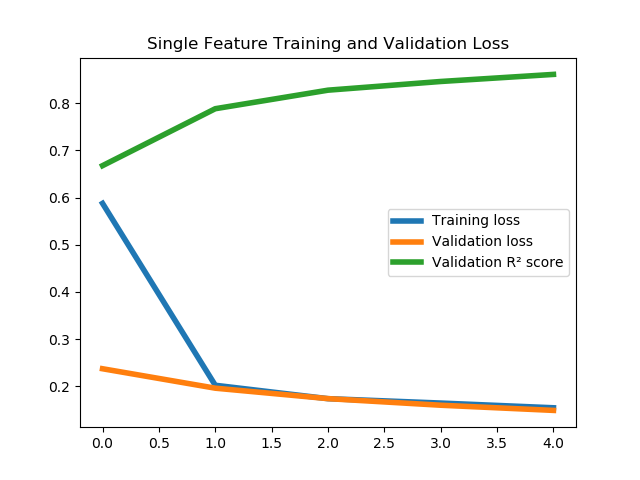

In [22]:
plot_train_history(single_feature_history, 'Single Feature Training and Validation Loss')

Checking the prediction:

In [23]:
# copy and paste your prediction command from above to save predictions into y_hat
### BEGIN SOLUTION
y_hat = single_feature_model.predict(x_test_single)
### END SOLUTION

<IPython.core.display.Javascript object>


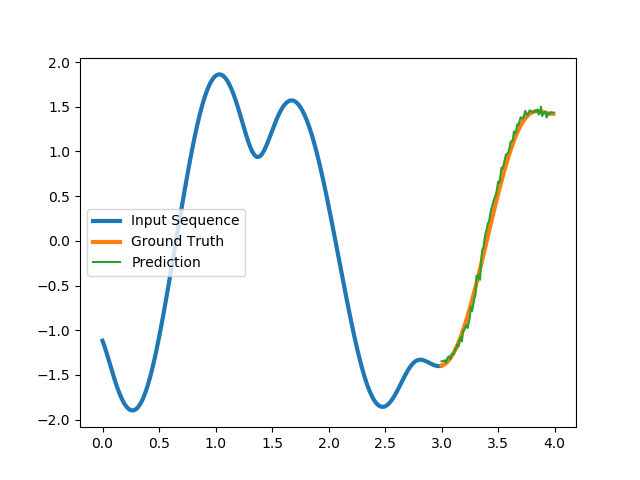

In [25]:
plt.figure()

plt.plot(t[:past_history], x_test_single[0,:,1], lw=3, label="Input Sequence")
plt.plot(t[past_history:past_history+future_target], y_test_single[0], lw=3, label="Ground Truth")
plt.plot(t[past_history:past_history+future_target], y_hat[0], label="Prediction")
plt.legend()

plt.show()

It seems to work much better. This is to be expected, since the other features encode the *microstate* of the system (its position in phase space). In other words, the total energy of the system depends on the features and the features change in such a way that the total energy is (or should be) conserved. Without knowledge of the behavior of the other features, the neural network has to learn the restrictions from the single curve alone, but energy is always distributed to different degrees of freedom in a system and there's no way to know how exactly that happens if the complete microstate is unknown (recall what entropy means here).

Finally, let's check the R² score on the test set:

In [26]:
single_feature_model.evaluate(x_test_single, y_test_single)

201/201 [==============================] - 0s 2ms/sample - loss: 0.1229 - r2_score: 0.7615


[0.12290673617699846, 0.76147854]

### Part 3: Multivariate Prediction of Multiple Features (10 points)
For these kinds of systems it's a bit tedious to repeat this procedure 4 times to predict all the features. It's possible to define a model that predicts all sequences at once. We can reuse the same data preparation function from before:

In [1]:
# testplit as usual, so we get untouched data for later evaluation
testsplit = int(0.8 * y.shape[0])

# how many "x" inputs to provide/how many timesteps to use in the RNN
past_history = 300

# how many "yhat" outputs to make/how many timesteps into the future to predict
future_target = 100

# this can be set to 1. If you have extremely large datasets where values 
# don't change a lot during single time steps, this can be set to a higher
# value such that, e.g., only every 6th time step is used 
step = 1

# prepare the data
# inputs here are y and y, since now we're predicting all features, using all features 
# "single_step" needs to be set to "True" if only the next timestep should be predicted
x_train_multi, y_train_multi = multivariate_data(y, y, 0, testsplit, 
                                                 past_history, future_target, step,
                                                 single_step=False)
x_test_multi, y_test_multi   = multivariate_data(y, y, testsplit, None, 
                                                 past_history, future_target, step,
                                                 single_step=False)

# print shapes
print("shape of y:", y.shape)
print("shapes of x_train and y_train: ", x_train_multi.shape, y_train_multi.shape)
print("shapes of x_test and y_test: ", x_test_multi.shape, y_test_multi.shape)

# print a few values
print("")
print(x_train_multi[:3,:3])

print()
# you can check other components by changing the last "1" index
print("x_train[300]: ", x_train_multi[300][:3][:,1], "...")
print("y_train[0] :  ", y_train_multi[0][:3][:,1], "...")

NameError: name 'y' is not defined

Now, the model itself needs a few adjustments. For every feature, we need to create a corresponding `Dense` layer that later outputs the desired prediction. Effectively, this creates 4 separate output layers connected to the same hidden layer. We'll use keras' functional API for this:

In [20]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.backend import clear_session

clear_session()

def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# create an "Input" layer with the correct shape to tell the network what to expect
inp = Input(x_train_multi.shape[-2:])

# directly assign an LSTM layer to a variable called "bm" here, similar to what
# we did in assignment 06 when creating a base model for image recognition
# it should look like "bm = ...(numberOfLSTMComponents)(inp)", the (inp) at the 
# end attaches this layer to the input layer
# use 128 components again
### BEGIN SOLUTION
bm = LSTM(128)(inp)
### END SOLUTION

# now we need 4 Dense layers. create 4 variables called "out1", "out2", "out3", and "out4"
# and directly assign them a Dense layer with a number of neuron equal to the number of
# time steps to predict into the future (saved in future_target) and an appropriate
# activation function. It should look like "out1 = ...(numberOfNeurons, activation=...)(bm)"
# the (bm) at the end attaches each output layer to the base model "bm"
### BEGIN SOLUTION
out1 = Dense(future_target, activation='selu')(bm)
out2 = Dense(future_target, activation='selu')(bm)
out3 = Dense(future_target, activation='selu')(bm)
out4 = Dense(future_target, activation='selu')(bm)
### END SOLUTION

# build the actual model
multi_feature_model = Model(inputs=inp, outputs=(out1,out2,out3,out4))

# compile the multi_feature model like in the parts before, with optimizer 'adam',
# an appropriate loss function and r2_score as a custom metric
### BEGIN SOLUTION
multi_feature_model.compile(optimizer='adam', loss='mae', metrics = [r2_score])
### END SOLUTION

# check that the model looks like expected
multi_feature_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 4)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 100, 256)     267264      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 256)          525312      lstm[0][0]                       
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          77100       lstm_1[0][0]                     
______________________________________________________________________________________________

In [29]:
assert "lstm" in str(bm)
assert bm.shape[-1] == 128

In [30]:
assert str(out1)[:70] == str(out2)[:70]
assert str(out1)[:70] == str(out3)[:70]
assert str(out1)[:70] == str(out4)[:70]


In [31]:
assert "InputLayer" in str(multi_feature_model.layers[0])
assert "LSTM" in str(multi_feature_model.layers[1])
for i in range(2, 6):
    assert "Dense" in str(multi_feature_model.layers[i])
assert multi_feature_model.layers[1].get_weights()[1].shape == (128, 512)


In [21]:
# we need to transpose the ground truth, because such a multi-output model
# expects a list of ground truths for each output layer
y_train_t = y_train_multi.transpose(2, 0, 1)
print(y_train_multi.shape)
print(y_train_t.shape)

# we can already unpack it into a list
y_train_t_u = [*y_train_t]

# fit the multi_feature_model here, using x_train_multi and y_train_t_u as training data, 5 epochs 
# and a validation split of 0.25
### BEGIN SOLUTION
multi_feature_history = multi_feature_model.fit(x_train_multi, y_train_t_u, epochs=5, validation_split=0.25)
### END SOLUTION

(2300, 300, 4)
(4, 2300, 300)
Train on 1725 samples, validate on 575 samples
Epoch 1/5
1725/1725 [==============================] - 64s 37ms/sample - loss: 1.6621 - dense_loss: 0.1817 - dense_1_loss: 0.4888 - dense_2_loss: 0.2295 - dense_3_loss: 0.7610 - dense_r2_score: 0.7846 - dense_1_r2_score: 0.7517 - dense_2_r2_score: 0.8064 - dense_3_r2_score: 0.6711 - val_loss: 0.9248 - val_dense_loss: 0.0673 - val_dense_1_loss: 0.2561 - val_dense_2_loss: 0.0783 - val_dense_3_loss: 0.5233 - val_dense_r2_score: 0.9754 - val_dense_1_r2_score: 0.9396 - val_dense_2_r2_score: 0.9826 - val_dense_3_r2_score: 0.8591
Epoch 2/5
1725/1725 [==============================] - 59s 34ms/sample - loss: 0.8826 - dense_loss: 0.0767 - dense_1_loss: 0.2393 - dense_2_loss: 0.0865 - dense_3_loss: 0.4800 - dense_r2_score: 0.9687 - dense_1_r2_score: 0.9472 - dense_2_r2_score: 0.9787 - dense_3_r2_score: 0.8720 - val_loss: 0.7363 - val_dense_loss: 0.0527 - val_dense_1_loss: 0.1995 - val_dense_2_loss: 0.0646 - val_dense_3_

In [33]:
assert multi_feature_history.history["val_dense_2_r2_score"][-1] > 0.75
assert "val_dense_3_r2_score" in multi_feature_history.history.keys()

Creating the predictions for the test set and undoing the transpose from before:

In [22]:
# since "predict" from a multi-output model will output a list of predictions
# it's a good idea to make it a numpy array for ease of use later on
y_hat = np.array(multi_feature_model.predict(x_test_multi)).transpose(1, 2, 0)

A slight modification of `plot_phis` from before:

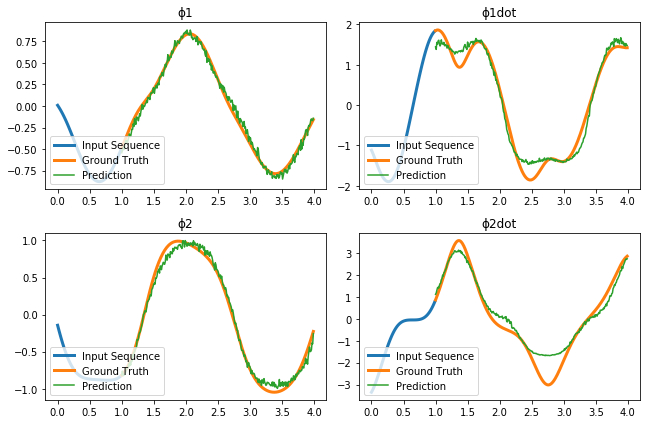

In [23]:
def plot_phis(t, X, y, y_hat):
    fig, axs = plt.subplots(2, 2, figsize=(9,6))
    axs = axs.flatten()
    titles = ["ϕ1", "ϕ1dot", "ϕ2", "ϕ2dot"]

    for i in range(len(axs)):
        axs[i].plot(t[:X[0].shape[0]], X[0,:,i], lw=3, label="Input Sequence")
        axs[i].plot(t[X[0].shape[0]:X[0].shape[0]+y[0].shape[0]], y[0,:,i], lw=3, label="Ground Truth")
        axs[i].plot(t[X[0].shape[0]:X[0].shape[0]+y[0].shape[0]], y_hat[0,:,i], label="Prediction")
        axs[i].set_title(titles[i])
        axs[i].legend(loc='lower left')
    
    plt.tight_layout()
        
plot_phis(t, x_test_multi, y_test_multi, y_hat)

And as a last step evaluate the model on the test set:

In [36]:
multi_feature_model.evaluate(x_test_multi, [*y_test_multi.transpose(2, 0, 1)])

201/201 [==============================] - 0s 2ms/sample - loss: 0.5119 - dense_loss: 0.0290 - dense_1_loss: 0.1318 - dense_2_loss: 0.0469 - dense_3_loss: 0.3641 - dense_r2_score: 0.9866 - dense_1_r2_score: 0.7685 - dense_2_r2_score: 0.9743 - dense_3_r2_score: 0.7640


[0.5118728538057697,
 0.029037211,
 0.1318111,
 0.046930593,
 0.3641478,
 0.9866152,
 0.7685088,
 0.9742546,
 0.7640036]

Of course this isn't publication-ready research, but using a method like this, the development of highly complex dynamic system could be predicted faster than with classical methods, but this remains to be investigated in each special case. It is important to perform some form of hyperparameter optimization and to make sure that the training is stable and the model reproducible.

---